In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from astropy.table import Table
import time
from pandas import DataFrame, read_csv
import pandas as pd 
from mpl_toolkits.mplot3d import Axes3D
import copy
import pickle

In [2]:
dic_AF = pickle.load( open( "Extinction_FiltersAll_G2_dr2.txt", "rb" ) ) 
AF=dic_AF['AF']
Av=dic_AF['Av']

Av = [ round(elem, 1) for elem in Av ]

G_K_int=dic_AF['G_K_int']

In [3]:
ind_G = 0
ind_Gb = 1
ind_Gr = 2
ind_H = 3
ind_J = 4
ind_K = 5

print(G_K_int[5])
#print(len(G_K_int))

-0.981866623564


In [4]:
file = r'Gaia_plx7_dr2.csv'
df = pd.read_csv(file)
df2 = df.columns.get_values()
df2.tolist()
print('Succesfully Read in the Data')

/astromake/opt/python/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (96,122,130) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Succesfully Read in the Data


In [5]:
Gmag = df["phot_g_mean_mag"].values
GBmag = df["phot_bp_mean_mag"].values
GRmag = df["phot_rp_mean_mag"].values
# 2MASS bands
Jmag = df["j_m"].values
Hmag = df["h_m"].values
Kmag = df["ks_m"].values
GK = Gmag - Kmag
# Other Important Data
plx = df["parallax"].values
Dist = 1000./plx
K_unc = df["ks_msigcom"].values
J_unc = df['j_msigcom'].values
H_unc = df['h_msigcom'].values
G_flux = df["phot_g_mean_flux"].values
G_flux_er = df["phot_g_mean_flux_error"].values
GB_flux = df['phot_bp_mean_flux'].values
GB_flux_er = df['phot_bp_mean_flux_error'].values
GR_flux = df['phot_rp_mean_flux'].values
GR_flux_er = df['phot_rp_mean_flux_error'].values
SNR = G_flux/G_flux_er

In [7]:
def StarFit(starBands,color_mags,color_std,spec):
    new_starBands = np.array(starBands)
#     for i in range(len(starBands)):
#         if(i == 0):
#             G = starBands[i]
#         else:
#             G_X = G - starBands[i]
#             new_starBands.append(G_X)
    
    template_bands = []
    template_err = []
    for i in range(len(color_mags)):
        cm = color_mags[i,:]
        cm = cm[~np.isnan(cm)]
        cs = color_std[i,:]
        cs = cs[~np.isnan(cs)]
        template_bands.append(cm)
        template_err.append(cs)
    template_bands = np.array(template_bands)
    template_err = np.array(template_err)
    
    Chi2_vals = []
    for i in range(len(template_bands)):
        Chi2 = 0
        for j in range(len(new_starBands)):
            Chi2 = Chi2 + ((template_bands[i,j] - new_starBands[j])**2/(template_err[i,j])**2)
        Chi2 = Chi2/(len(new_starBands)-1)  # EDITED THIS LINE JUNE 7TH. GOT RID OF THE -1
        Chi2_vals.append(Chi2)
    Chi2_vals = np.array(Chi2_vals)
    
    red_Chi2 = []
    for i in range(len(Chi2_vals)):
        if(Chi2_vals[i] == np.min(Chi2_vals)):
            chi_val = Chi2_vals[i]
            
            
            best_fit = i
            
            #index = G_K_int[spec[i]]
            GK_val = spec #G_K_int[index]
#             print('The best Template is '+ str((best_fit+1)) +' out of '+str(len(template_bands))+ ' templates')
#             print('Or ' + str(best_fit) + ' out of ' + str((len(template_bands)-1)))
    #print(best_fit)
    return best_fit, new_starBands, chi_val, GK_val

In [6]:
def ColorClassification(Gmags,Kmags,colors):    
    #assign the stars into different categories based on G-K
    
    #Variables Read In
    #Gmags: numpy array of absolute magnitudes in G
    #Kmags: numpy array of absolute magnitudes in K
    #colors: list or array of values of G-K in increasing order
    
    #Variables Returned
    #color: numpy array that indicates the category of G-K that each star belongs to
    
    #caclculate the values of G-K for all stars
    
    G_K = Gmags-Kmags
    
    #create array to hold the G-K color categories 
    color = np.ones(len(G_K))*1000
    
    #compare the value of G-K for each star to the categories and assign a corresponding
    #value for the category in the color array
    for i in range(len(colors)):
        for j in range(len(G_K)):
            if (i == 0):
                if (G_K[j] <= colors[i]):
                    color[j] = colors[i]
            elif(G_K[j] <= colors[i] and G_K[j] > colors[i-1]):
                color[j] = colors[i]
    return color

In [7]:
def CreateTemplates(color,colors,Gmags,Kmags,GB_mags=[999],GR_mags=[999],J_mags=[999],H_mags=[999],umags=[999],gmags=[999],rmags=[999],imags=[999],zmags=[999]):
    #For each category of G-K, a template is created of the absolute magnitudes of the stars and their color indices 
    #calculated with bands of different magnitudes
    # ** Gmags and Kmags is REQUIRED ** 
    #Variables Read In:
    #color: numpy array that indicates the category of G-K that each star belongs to
    #colors: list or array of values of G-K in increasing order
    #GBmags: numpy array of absolute magnitudes in GB
    #GRmags: numpy array of absolute magnitudes in GR
    #Gmags: numpy array of absolute magnitudes in G
    #Jmags: numpy array of absolute magnitudes in J
    #Hmags: numpy array of absolute magnitudes in H 
    #Kmags: numpy array of absolute magnitudes in K
    #umags: numpy array of absolute magnitudes in u
    #gmags: numpy array of absolute magnitudes in g
    #rmags: numpy array of absolute magnitudes in r
    #imags: numpy array of absolute magnitudes in i
    #zmags: numpy array of absolute magnitudes in z
    
    #Variables Returned: 
    #stars: array of the number of stars in each category of G-K
    #color_mags: array of the color indices at each wavelength for all of the categories of G-K
    #color_std: array of the standard deviation of color indices at each wavelength for all of the categories of G-K
    #color_std_err: array of the standard deviation error of thecolor indices at each wavelength for all of the categories of G-K
    #abs_color_mags: array of the average absolute magnitudes in each band for all of the categories of G-K
    #abs_color_std: array of the standard deviation of absolute magnitudes in each band for all of the categories of G-K
    #abs_color_std_err: array of the standard deviation error of absolute magnitudes in each band for all categores of G-K
    
    if(len(GB_mags) < 2):
        GB_mags = np.ones(len(Gmags))*np.nan
    if(len(GR_mags) < 2):
        GR_mags = np.ones(len(Gmags))*np.nan
    if(len(J_mags) < 2):
        J_mags = np.ones(len(Gmags))*np.nan
    if(len(H_mags) < 2):
        H_mags = np.ones(len(Gmags))*np.nan
    if(len(umags) < 2):
        umags = np.ones(len(Gmags))*np.nan
    if(len(gmags) < 2):
        gmags = np.ones(len(Gmags))*np.nan
    if(len(zmags) < 2):
        zmags = np.ones(len(Gmags))*np.nan
    if(len(imags) < 2):
        imags = np.ones(len(Gmags))*np.nan
    if(len(rmags) < 2):
        rmags = np.ones(len(Gmags))*np.nan
    
    
    #Calculate the values of G-K for each star
    G_K = Gmags-Kmags
    
    #create array to hold the number of stars in each template: 
    stars = np.array([])
    
    for c in colors:
        #create array of values for color indices and absolute magnitudes
        G_GB_array = np.array([])
        G_GR_array = np.array([])
        G_J_array = np.array([])
        G_H_array = np.array([])
        G_K_array = np.array([])
        G_u_array = np.array([])
        G_g_array = np.array([])
        G_r_array = np.array([])
        G_i_array = np.array([])
        G_z_array = np.array([])
        GB = np.array([])
        GR = np.array([])
        G = np.array([])
        J = np.array([])
        H = np.array([])
        K = np.array([])
        u = np.array([])
        g = np.array([])
        r = np.array([])
        i_m = np.array([])
        z = np.array([])
        star_count = 0
        #fill arrays with values if the values are part of the color category
        for i in range(len(Gmags)):
            if (color[i] == c):
                
                G_GB_array = np.append(G_GB_array,Gmags[i]-GB_mags[i])
                G_GR_array = np.append(G_GR_array,Gmags[i]-GR_mags[i])
                G_J_array = np.append(G_J_array,Gmags[i]-J_mags[i])
                G_H_array = np.append(G_H_array,Gmags[i]-H_mags[i])
                G_K_array = np.append(G_K_array,Gmags[i]-Kmags[i])
                G_u_array = np.append(G_u_array,Gmags[i]-umags[i])
                G_g_array = np.append(G_g_array,Gmags[i]-gmags[i])
                G_r_array = np.append(G_r_array,Gmags[i]-rmags[i])
                G_i_array = np.append(G_i_array,Gmags[i]-umags[i])
                G_z_array = np.append(G_z_array,Gmags[i]-zmags[i])
                GB = np.append(GB,GB_mags[i])
                GR = np.append(GR,GR_mags[i])
                G = np.append(G,Gmags[i])
                J = np.append(J,J_mags[i])
                H = np.append(H,H_mags[i])
                K = np.append(K,Kmags[i])
                u = np.append(u,umags[i])
                g = np.append(g,umags[i])
                r = np.append(r,rmags[i])
                i_m = np.append(i_m,imags[i])
                z = np.append(z,zmags[i])
                star_count = star_count +1
        #number of stars per color
        stars = np.append(stars,star_count)
        #relative SED
        mag_array = [np.nanmean(G_u_array),np.nanmean(G_g_array), np.nanmean(G_GB_array),\
                     np.nanmean(G_r_array),np.nanmean(G_i_array), np.nanmean(G_GR_array), \
                     np.nanmean(G_z_array),np.nanmean(G_J_array), np.nanmean(G_H_array), \
                     np.nanmean(G_K_array)]
        std_array = [np.nanstd(G_u_array),np.nanstd(G_g_array), np.nanstd(G_GB_array),\
                     np.nanstd(G_r_array),np.nanstd(G_i_array), np.nanstd(G_GR_array), \
                     np.nanstd(G_z_array),np.nanstd(G_J_array), np.nanstd(G_H_array), \
                     np.nanstd(G_K_array)]
        #absolute SED
        mag_array2 = [np.nanmean(u), np.nanmean(g), np.nanmean(GB), \
                      np.nanmean(r), np.nanmean(G), np.nanmean(i), \
                      np.nanmean(GR), np.nanmean(z), np.nanmean(J), \
                      np.nanmean(H), np.nanmean(K)]
        std_array2 = [np.nanstd(u), np.nanstd(g), np.nanstd(GB), \
                      np.nanstd(r), np.nanstd(G), np.nanstd(i_m), \
                      np.nanstd(GR), np.nanstd(z), np.nanstd(J), \
                      np.nanstd(H), np.nanstd(K)]
        #calculate standard deviation error
        val = np.sqrt(len(G_u_array))
        std_array3 = std_array/val
        val2 = np.sqrt(len(u))
        std_array4 = std_array2/val2
        #stack SEDs
        if (c == colors[0]):
            
            color_mags = np.array(mag_array)
            color_std = np.array(std_array)
            color_std_err = np.array(std_array3)
            abs_color_mags = np.array(mag_array2)
            abs_color_std = np.array(std_array2)
            abs_color_std_err = np.array(std_array4)
        else:
            #print(len(color_mags),len(mag_array))
            color_mags = np.vstack((color_mags,mag_array))
            color_std = np.vstack((color_std,std_array))
            color_std_err = np.vstack((color_std_err,std_array3))
            #print('\n',len(abs_color_mags),len(mag_array2))
            abs_color_mags = np.vstack((abs_color_mags, mag_array2))
            abs_color_std = np.vstack((abs_color_mags, std_array2))
            abs_color_std_err = np.vstack((abs_color_std_err,std_array4))
            #A[~np.isnan(A)])
    #print((color_mags))
#     color_mags = color_mags[~np.isnan(color_mags)]
#     #print(len(color_mags))
#     color_std = color_std[~np.isnan(color_std)]
#     color_std_err = color_std_err[~np.isnan(color_std_err)]
#     abs_color_mags = abs_color_mags[~np.isnan(abs_color_mags)]
#     abs_color_std = abs_color_std[~np.isnan(abs_color_std)]
#     abs_color_std_err = abs_color_std_err[~np.isnan(abs_color_std_err)]
#     color_mags = np.reshape(color_mags, (-1, 10))
#     color_std = np.reshape(color_std, (-1, 10))
#     color_std_err = np.reshape(color_std_err, (-1, 10))
#     print(color_mags,'\n',abs_color_mags)
#     abs_color_mags = np.reshape(abs_color_mags, (-1, 11))
#     abs_color_std = np.reshape(abs_color_std, (-1, 11))
#     abs_color_std_err = np.reshape(abs_color_std_err, (-1, 11))
            
    return stars,color_mags,color_std,color_std_err,abs_color_mags,abs_color_std,abs_color_std_err

In [8]:
def MagError(flux2,flux2_er,min_val):
    
    #Mag = 2.5*np.log10(flux1/flux2) + KnownMag
    Mag_er = np.sqrt((2.5/np.log(10)**2)*(flux2_er/flux2)**2)
    #Mag_er = np.sqrt(((2.5/(np.log(10)*flux1))*flux1_er)**2 + ((-2.5/(np.log(10)*flux2))*flux2_er)**2)
    if(Mag_er < min_val):
        Mag_er = min_val
    return Mag_er

In [11]:
# FIT FUNCTION USING BOTH STAR MAG UNCERTAINTY AND STANDARD ERROR IN TEMPLATE
def StarFitting(starBands,color_mags,starError,color_std,spec):
    
    #new_starBands = []
    
    new_starBands = np.array(starBands)
#     for i in range(len(starBands)):
#         if(i == 0):
#             G = starBands[i]
#         else:
#             G_X = G - starBands[i]
#             new_starBands.append(G_X)
#     old_bands = []
#     for i in range(len(old_mags)):
#         cm = old_mags[i,:]
#         cm = cm[~np.isnan(cm)]
        
#         old_bands.append(cm)
#     old_bands = np.array(old_bands)
    
    template_bands = []
    template_err = []
    for i in range(len(color_mags)):
        cm = color_mags[i,:]
        cm = cm[~np.isnan(cm)]
        cs = color_std[i,:]
        cs = cs[~np.isnan(cs)]
        template_bands.append(cm)
        template_err.append(cs)
    template_bands = np.array(template_bands)
    template_err = np.array(template_err)
    
    newStarError = []
    for i in range(len(starError)):
        if(i == 0):
            sigmaG = starError[i]
        else:
            sigma = starError[i]
            newStarError.append(np.sqrt(sigmaG**2+sigma**2))
    newStarError = np.array(newStarError)
    Chi2_vals = []
    
    QuadError = []
    for i in range(len(template_err)):
        QuadError.append(np.sqrt(newStarError**2 + template_err[i]**2))
    QuadError = np.array(QuadError)

    
    for i in range(len(template_bands)):
        #print(new_starBands,'\n',template_bands[i],'\n',QuadError[i])
        Chi2 = ((template_bands[i] - new_starBands)**2/(newStarError)**2)
        Chi2 = np.sum(Chi2)
        
#         Chi2 = 0
#         for j in range(len(new_starBands)):
#             Chi2 = Chi2 + ((template_bands[i,j] - new_starBands[j])**2/(QuadError[i,j])**2)
        Chi2 = Chi2/(len(new_starBands)-1)  # EDITED THIS LINE JUNE 7TH. GOT RID OF THE -1
        Chi2_vals.append(Chi2)
    
    #Chi2_vals = np.array(Chi2_vals)
   
    red_Chi2 = []
    for i in range(len(Chi2_vals)):
        if(Chi2_vals[i] == np.min(Chi2_vals)):
            chi_val = Chi2_vals[i]
            
            best_fit = i
            #GK_val = spec
            
            Index = int(spec[i])
            val = G_K_int[Index]
            #GK_val = val #G_K_int[index]
    return best_fit, new_starBands, newStarError, chi_val, val

In [159]:
# FIT FUNCTION USING BOTH STAR MAG UNCERTAINTY AND STANDARD ERROR IN TEMPLATE
def StarFitQuad(starBands,color_mags,starError,color_std,spec):
    
    new_starBands = []
    
    #new_starBands = np.array(starBands)
    for i in range(len(starBands)):
        if(i == 0):
            G = starBands[i]
        else:
            G_X = G - starBands[i]
            new_starBands.append(G_X)
    new_starBands = np.array(new_starBands)
#     old_bands = []
#     for i in range(len(old_mags)):
#         cm = old_mags[i,:]
#         cm = cm[~np.isnan(cm)]
        
#         old_bands.append(cm)
#     old_bands = np.array(old_bands)
    
    template_bands = []
    template_err = []
    for i in range(len(color_mags)):
        cm = color_mags[i,:]
        cm = cm[~np.isnan(cm)]
        cs = color_std[i,:]
        cs = cs[~np.isnan(cs)]
        template_bands.append(cm)
        template_err.append(cs)
    template_bands = np.array(template_bands)
    template_err = np.array(template_err)
    
    newStarError = []
    for i in range(len(starError)):
        if(i == 0):
            sigmaG = starError[i]
        else:
            sigma = starError[i]
            newStarError.append(np.sqrt(sigmaG**2+sigma**2))
    newStarError = np.array(newStarError)
    Chi2_vals = []
    
#     QuadError = []
#     for i in range(len(template_err)):
#         QuadError.append(np.sqrt(newStarError**2 + template_err[i]**2))
#     QuadError = np.array(QuadError)
    
    QuadError = []
    for i in range(len(template_err)):
        QuadError.append(np.sqrt(newStarError**2 + template_err[i]**2))
    QuadError = np.array(QuadError)

    GK_chi = []
    for i in range(len(template_bands)):
        #print(new_starBands,'\n',template_bands[i],'\n',QuadError[i])
        Chi2 = ((template_bands[i] - new_starBands)**2/(QuadError[i])**2)
        Chi2 = np.sum(Chi2)
        
#         Chi2 = 0
#         for j in range(len(new_starBands)):
#             Chi2 = Chi2 + ((template_bands[i,j] - new_starBands[j])**2/(QuadError[i,j])**2)
        Chi2 = Chi2/(len(new_starBands)-1)  # EDITED THIS LINE JUNE 7TH. GOT RID OF THE -1
        Chi2_vals.append(Chi2)
    
    #Chi2_vals = np.array(Chi2_vals)
   
    red_Chi2 = []
    for i in range(len(Chi2_vals)):
        if(Chi2_vals[i] == np.min(Chi2_vals)):
            chi = Chi2_vals[i]
            
            best_fit = i
            #GK_val = spec
            
            Index = int(spec[i])
            val = G_K_int[Index]
            #GK_val = val #G_K_int[index]
    return best_fit, chi, val, Chi2_vals

In [10]:
def addExtinctionStar(starData,idx,Ao):
    # Relative Bands G-X
#     if(n == 1):
    G_GB = starData[0] - starData[1]
    G_GR = starData[0] - starData[2]
    G_J = starData[0] - starData[3]
    G_H = starData[0] - starData[4]
    G_K = starData[0] - starData[5]
#     if(n == 0):
#     G_GB = starData[2] 
#     G_GR = starData[5] 
#     G_J = starData[7] 
#     G_H = starData[8] 
#     G_K = starData[9]
#     else:
#         print('Error, Incorrect value for n')
#         return
#     colorDiff = list(abs(G_K_int - tempColor))
#     minVal = np.min(colorDiff)
#     ind = colorDiff.index(minVal)
    
    AV = list(copy.copy(Av))
    A_v = AV.index(Ao) 
    
    
    # Extinction Coefficients
    A_G = AF[idx,ind_G,A_v]
    A_GB = AF[idx,ind_Gb,A_v]
    A_GR = AF[idx,ind_Gr,A_v]
    A_H = AF[idx,ind_H,A_v]
    A_J = AF[idx,ind_J,A_v]
    A_K = AF[idx,ind_K,A_v]
    
    # Extinction Vals
#     extG_GB = G_GB + (A_G - A_GB)*Ao
#     extG_GR = G_GR + (A_G - A_GR)*Ao
#     extG_H = G_H + (A_G - A_H)*Ao
#     extG_J = G_J + (A_G - A_J)*Ao
#     extG_K = G_K + (A_G - A_K)*Ao
    
    
    extG_GB = G_GB + (A_G - A_GB)
    extG_GR = G_GR + (A_G - A_GR)
    extG_H = G_H + (A_G - A_H)
    extG_J = G_J + (A_G - A_J)
    extG_K = G_K + (A_G - A_K)
    
    
    relBands = [G_GB,G_GR,G_J,G_H,G_K]
    extBands = [extG_GB,extG_GR,extG_J,extG_H,extG_K]
        
    return relBands, extBands    

In [12]:
def addExtinctionTemp(starData,idx,Ao):
    # Relative Bands G-X
#     if(n == 1):
#     G_GB = starData[0] - starData[1]
#     G_GR = starData[0] - starData[2]
#     G_J = starData[0] - starData[3]
#     G_H = starData[0] - starData[4]
#     G_K = starData[0] - starData[5]
#     if(n == 0):
    G_GB = starData[2] 
    G_GR = starData[5] 
    G_J = starData[7] 
    G_H = starData[8] 
    G_K = starData[9]
#     else:
#         print('Error, Incorrect value for n')
#         return
#     colorDiff = list(abs(G_K_int - tempColor))
#     minVal = np.min(colorDiff)
#     ind = colorDiff.index(minVal)
    
    AV = list(copy.copy(Av))
    A_v = AV.index(Ao) 
    
    
    # Extinction Coefficients
    A_G = AF[idx,ind_G,A_v]
    A_GB = AF[idx,ind_Gb,A_v]
    A_GR = AF[idx,ind_Gr,A_v]
    A_H = AF[idx,ind_H,A_v]
    A_J = AF[idx,ind_J,A_v]
    A_K = AF[idx,ind_K,A_v]
    
    # Extinction Vals
#     extG_GB = G_GB + (A_G - A_GB)*Ao
#     extG_GR = G_GR + (A_G - A_GR)*Ao
#     extG_H = G_H + (A_G - A_H)*Ao
#     extG_J = G_J + (A_G - A_J)*Ao
#     extG_K = G_K + (A_G - A_K)*Ao
    
    extG_GB = G_GB + (A_G - A_GB)
    extG_GR = G_GR + (A_G - A_GR)
    extG_H = G_H + (A_G - A_H)
    extG_J = G_J + (A_G - A_J)
    extG_K = G_K + (A_G - A_K)
    
    
    relBands = [G_GB,G_GR,G_J,G_H,G_K]
    extBands = [extG_GB,extG_GR,extG_J,extG_H,extG_K]
        
    return relBands, extBands    

In [13]:
def findStar():
    idx = np.random.randint(1,len(G_K_int))
    GK_val = G_K_int[idx]
    GK_val = round(GK_val, 4)
    #print(GK_val)
    count = 0
    array = []
    color = []
    for i in range(len(good_GK)):
        curGK = good_GK[i]
        
        curGK = round(curGK, 4)
        if(GK_val == curGK):
            color.append(curGK)
            count = count + 1
            array.append(i)
    return count, array, idx, color


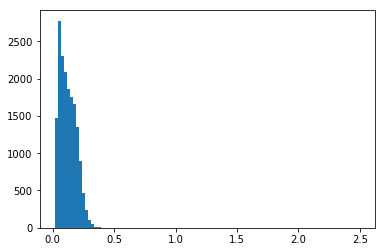

0.124386669129


In [83]:
j = np.array(copy.copy(K_unc_dm))
j = j[~np.isnan(j)]
plt.hist(j,100)
plt.show()
print(np.mean(j))

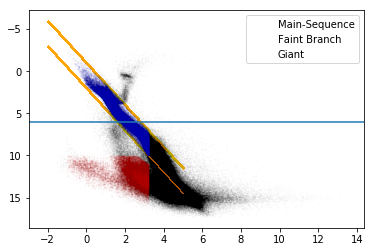

Giant Stars: 0
3.20610222406


In [15]:
x = np.linspace(-2,5,len(Gmag))
MS_min = 2.5*x-1
MS_max = 2.5*x+2.0
GK = Gmag - Kmag
plt.scatter(GK,Gmags,s=1.0,alpha=0.01,c='k')
plt.scatter(x,MS_min,alpha=0.01,s=1.0,c='orange')
plt.scatter(x,MS_max,alpha=0.01,s=1.0,c='orange')
plt.scatter(br_GK,br_G,s=1.2,alpha=0.01,c='blue',label='Main-Sequence')
plt.scatter(dm_GK,dm_G,s=1.2,alpha=0.01,c='red',label='Faint Branch')
plt.scatter(giantGK,giantG,s=1.2,alpha=0.03,c='orange',label='Giant')
plt.legend()
plt.gca().invert_yaxis()
plt.axhline(6)
# plt.axvline(1.7)
# plt.axvline(3)
# plt.axhline(5)
# plt.axhline(6)
plt.show()
print('Giant Stars:',len(giantGK))
print(np.max(G_K_int))

In [83]:
Gmags = Gmag - 5 * np.log10(Dist) + 5
GK = Gmag - Kmag
br_Gmag = []
br_Gflux = []
br_Gflux_er = []
br_GBmag = []
br_GBflux = []
br_GBflux_er = []
br_GRmag = []
br_GRflux = []
br_GRflux_er = []
br_Jmag = []
br_Hmag = []
br_Kmag = []
br_GK = []
br_G = []
J_unc_br = []
H_unc_br = []
K_unc_br = []
SNR_br = []

# MS_min = 2.5*x-1
# MS_max = 2.5*x+1.5

for i in range(len(Gmags)):
    if(Gmags[i] < 10 and GK[i] >= np.min(G_K_int) and GK[i] <= np.max(G_K_int) and \
       (Gmags[i] > GK[i]*2.5-1) and (Gmags[i] < GK[i]*2.5+2) \
       and SNR[i] > 400):
    #if(SNR[i] > 50):
        br_Gmag.append(Gmag[i])
        br_GBmag.append(GBmag[i]) 
        br_GRmag.append(GRmag[i])
        br_Jmag.append(Jmag[i])
        br_Hmag.append(Hmag[i])
        br_Kmag.append(Kmag[i])
        br_GK.append(GK[i])
        br_G.append(Gmags[i])
        br_Gflux.append(G_flux[i])
        br_Gflux_er.append(G_flux_er[i])
        br_GBflux.append(GB_flux[i])
        br_GBflux_er.append(GB_flux_er[i])
        br_GRflux.append(GR_flux[i])
        br_GRflux_er.append(GR_flux_er[i])
        J_unc_br.append(J_unc[i])
        H_unc_br.append(H_unc[i])
        K_unc_br.append(K_unc[i])
        SNR_br.append(G_flux[i]/G_flux_er[i])
        
SNR_br = np.array(SNR_br)
br_Gmag = np.array(br_Gmag)
br_GBmag = np.array(br_GBmag)
br_GRmag = np.array(br_GRmag)
br_Jmag = np.array(br_Jmag)
br_Hmag = np.array(br_Hmag)
br_Kmag = np.array(br_Kmag)
br_Gflux = np.array(br_Gflux)
br_Gflux_er = np.array(br_Gflux_er)
br_GBflux = np.array(br_GBflux)
br_GBflux_er = np.array(br_GBflux_er)
br_GRflux = np.array(br_GRflux)
br_GRflux_er = np.array(br_GRflux_er)
br_GK = np.array(br_GK)
br_G = np.array(br_G)
all_BrightStars = np.transpose([br_Gmag,br_GBmag,br_GRmag,br_Jmag,br_Hmag,br_Kmag])
print('Length of Br_Mags:',len(br_Gmag))

dm_G = []
dm_Gmag = []
dm_GBmag = []
dm_GRmag = []
dm_Jmag = []
dm_Hmag = []
dm_Kmag = []
dm_GK = []
dm_Gflux = []
dm_Gflux_er = []
dm_GBflux = []
dm_GBflux_er = []
dm_GRflux = []
dm_GRflux_er = []
J_unc_dm = []
H_unc_dm = []
K_unc_dm = []
SNR_dm = []
for i in range(len(Gmags)):
    if(Gmags[i] > 10 and GK[i] >= np.min(G_K_int) and GK[i] <= np.max(G_K_int) and \
       (Gmags[i] > 1.8*GK[i]+5.3) and SNR[i] > 400):       
        dm_Gmag.append(Gmag[i])
        dm_GBmag.append(GBmag[i])
        dm_GRmag.append(GRmag[i])
        dm_Jmag.append(Jmag[i])
        dm_Hmag.append(Hmag[i])
        dm_Kmag.append(Kmag[i])
        dm_GK.append(GK[i])
        dm_G.append(Gmags[i])
        dm_Gflux.append(G_flux[i])
        dm_Gflux_er.append(G_flux_er[i])
        dm_GBflux.append(GB_flux[i])
        dm_GBflux_er.append(GB_flux_er[i])
        dm_GRflux.append(GR_flux[i])
        dm_GRflux_er.append(GR_flux_er[i])
        J_unc_dm.append(J_unc[i])
        H_unc_dm.append(H_unc[i])
        K_unc_dm.append(K_unc[i])
        SNR_dm.append(G_flux[i]/G_flux_er[i])
SNR_dm = np.array(SNR_dm)
dm_Gflux = np.array(dm_Gflux)
dm_Gflux_er = np.array(dm_Gflux_er)
dm_GBflux = np.array(dm_GBflux)
dm_GBflux_er = np.array(dm_GBflux_er)
dm_GRflux = np.array(dm_GRflux)
dm_GRflux_er = np.array(dm_GRflux_er)
dm_Gmag = np.array(dm_Gmag)
dm_GBmag = np.array(dm_GBmag)
dm_GRmag = np.array(dm_GRmag)
dm_Jmag = np.array(dm_Jmag)
dm_Hmag = np.array(dm_Hmag)
dm_Kmag = np.array(dm_Kmag)
dm_GK = np.array(dm_GK)
dm_G = np.array(dm_G)
all_dimStars = np.transpose([dm_Gmag,dm_GBmag,dm_GRmag,dm_Jmag,dm_Hmag,dm_Kmag])
print('Length of dm_Mags:',len(dm_Gmag))

giantGmag = []
giantGflux = []
giantGflux_er = []
giantGBmag = []
giantGBflux = []
giantGBflux_er = []
giantGRmag = []
giantGRflux = []
giantGRflux_er = []
giantJmag = []
giantHmag = []
giantKmag = []
giantGK = []
giantG = []
J_unc_giant = []
H_unc_giant = []
K_unc_giant = []

# for i in range(len(Gmags)):
#     if(Gmags[i] < 0.85 and GK[i] >= 1.6 and GK[i] <= np.max(G_K_int) and Gmags[i] < MS_min[i]):
#         giantGmag.append(Gmag[i])
#         giantGBmag.append(GBmag[i])
#         giantGRmag.append(GRmag[i])
#         giantJmag.append(Jmag[i])
#         giantHmag.append(Hmag[i])
#         giantKmag.append(Kmag[i])
#         giantGK.append(GK[i])
#         giantG.append(Gmags[i])
#         giantGflux.append(G_flux[i])
#         giantGflux_er.append(G_flux_er[i])
#         giantGBflux.append(GB_flux[i])
#         giantGBflux_er.append(GB_flux_er[i])
#         giantGRflux.append(GR_flux[i])
#         giantGRflux_er.append(GR_flux_er[i])
#         J_unc_giant.append(J_unc[i])
#         H_unc_giant.append(H_unc[i])
#         K_unc_giant.append(K_unc[i])
    
# giantGmag = np.array(giantGmag)
# giantGBmag = np.array(giantGBmag)
# giantGRmag = np.array(giantGRmag)
# giantJmag = np.array(giantJmag)
# giantHmag = np.array(giantHmag)
# giantKmag = np.array(giantKmag)
# giantGflux = np.array(giantGflux)
# giantGflux_er = np.array(giantGflux_er)
# giantGBflux = np.array(giantGBflux)
# giantGBflux_er = np.array(giantGBflux_er)
# giantGRflux = np.array(giantGRflux)
# giantGRflux_er = np.array(giantGRflux_er)
# giantGK = np.array(giantGK)
# giantG = np.array(giantG)
# all_giantStars = np.transpose([giantGmag,giantGBmag,giantGRmag,giantJmag,giantHmag,giantKmag])
# print('Length of Br_Mags:',len(giantGmag))

Length of Br_Mags: 186456
Length of dm_Mags: 6009


In [84]:
br_colors = np.arange(np.min(br_GK),np.max(br_GK),0.03) # EDIT THIS TO USE DESIRED NUMBER OF COLORS/TEMPLATES
dm_colors = np.arange(np.min(dm_GK),np.max(dm_GK),0.03) # EDIT THIS TO USE DESIRED NUMBER OF COLORS/TEMPLATES

#MS_colors = G_K_int

#giant_colors = np.arange(np.min(giantGK),np.max(giantGK),0.03)
# BRIGHT STARS
color_br = ColorClassification(br_Gmag,br_Kmag,br_colors)
color_dm = ColorClassification(dm_Gmag,dm_Kmag,dm_colors)
#color_Giant = ColorClassification(giantGmag,giantKmag,giant_colors)

stars_br,color_mags_br,color_std_br,color_std_err_br,abs_color_mags_br,abs_color_std_br,abs_color_std_err_br = \
CreateTemplates(color_br,br_colors,Gmags=br_Gmag,Kmags=br_Kmag,GB_mags=br_GBmag,GR_mags=br_GRmag,J_mags=br_Jmag,H_mags=br_Hmag)

stars_dm,color_mags_dm,color_std_dm,color_std_err_dm,abs_color_mags_dm,abs_color_std_dm,abs_color_std_err_dm = \
CreateTemplates(color_dm,dm_colors,dm_Gmag,dm_Kmag,GB_mags=dm_GBmag,GR_mags=dm_GRmag,J_mags=dm_Jmag,H_mags=dm_Hmag)

#GiantStars,color_mags_Giant,color_std_Giant,color_std_err_Giant,abs_color_mags_Giant,abs_color_std_Giant,abs_color_std_err_Giant = \
#CreateTemplates(color_Giant,giant_colors,giantGmag,giantKmag,GB_mags=giantGBmag,GR_mags=giantGRmag,J_mags=giantJmag,H_mags=giantHmag)

/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: Mean of empty slice
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: Mean of empty slice


In [155]:
# CALCULATE UNCERTAINTIES IN FAINT G BAND
G_unc_dm = []

for i in range(0,len(dm_Gmag)):
    
    flux = dm_Gflux[i]
    flux_er = dm_Gflux_er[i]
    Mag_er = MagError(flux,flux_er,0.001)
    G_unc_dm.append(Mag_er)

G_unc_dm = np.array(G_unc_dm)

# CALCULATE UNCERTAINTIES IN FAINT GR BAND
GR_unc_dm = []

for i in range(0,len(dm_Gmag)):
    
    flux = dm_GRflux[i]
    flux_er = dm_GRflux_er[i]
    Mag_er = MagError(flux,flux_er,10**-2.5)
    GR_unc_dm.append(Mag_er)

GR_unc_dm = np.array(GR_unc_dm)

# CALCULATE UNCERTAINTIES IN FAINT GB BAND
GB_unc_dm = []

for i in range(0,len(dm_Gmag)):
    
    flux = dm_GBflux[i]
    flux_er = dm_GBflux_er[i]
    Mag_er = MagError(flux,flux_er,10**-2.5)
    GB_unc_dm.append(Mag_er)

GB_unc_dm = np.array(GB_unc_dm)


In [156]:
# CALCULATE UNCERTAINTIES IN BRIGHT G BAND
G_unc_br = []

for i in range(0,len(br_Gmag)):
    
    flux = br_Gflux[i]
    flux_er = br_Gflux_er[i]
    Mag_er = MagError(flux,flux_er,0.001)
    G_unc_br.append(Mag_er)

G_unc_br = np.array(G_unc_br)

# CALCULATE UNCERTAINTIES IN BRIGHT GR BAND
GR_unc_br = []

for i in range(0,len(br_Gmag)):
    
    flux = br_GRflux[i]
    flux_er = br_GRflux_er[i]
    Mag_er = MagError(flux,flux_er,10**-2.5)
    GR_unc_br.append(Mag_er)

GR_unc_br = np.array(GR_unc_br)

# CALCULATE UNCERTAINTIES IN BRIGHT GB BAND
GB_unc_br = []

for i in range(0,len(br_Gmag)):
    
    flux = br_GBflux[i]
    flux_er = br_GBflux_er[i]
    Mag_er = MagError(flux,flux_er,10**-2.5)
    GB_unc_br.append(Mag_er)

GB_unc_br = np.array(GB_unc_br)


In [161]:
mags_br = []
std_br = []
for i in range(len(stars_br)):
    if(stars_br[i] > 0):
        mags_br.append(color_mags_br[i])
        std_br.append(color_std_err_br[i])
#del BrightTemps[33:34]
#BrightTemps = BrightTemps[18:len(BrightTemps)]
mags_br = np.array(mags_br)
std_br = np.array(std_br)
star_err_br = np.transpose([G_unc_br,GB_unc_br,GR_unc_br,J_unc_br,H_unc_br,K_unc_br])

Chi2_br_SNR = []
Chi2_dm = []

for i in range(len(br_Gmag)):
    starBand = all_BrightStars[i]
    starBand = np.array(starBand)
    starBand = starBand[~np.isnan(starBand)]
    starError = star_err_br[i]
    starError = starError[~np.isnan(starError)]
    if(len(starBand) == len(all_BrightStars[i]) and len(starError) == len(star_err_br[i])):
        fit_br,chi2, array1, array2 = StarFitQuad(starBand,mags_br,starError,std_br,spec_br)
        Chi2_br_SNR.append(chi2)
        
Chi2_br_SNR = np.array(Chi2_br_SNR)

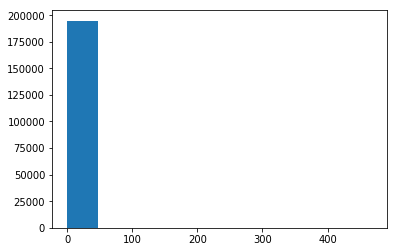

0.6770991478323548
0.3002468759512993
467.81873459070505


In [1328]:
plt.hist(Chi2_br_SNR)
plt.show()
print(np.mean(Chi2_br_SNR))
print(np.median(Chi2_br_SNR))
print(np.max(Chi2_br_SNR))

In [1386]:
print(len(br_Gflux))

196247


In [1411]:
bands = []
error = []
new_GK = []
newJ_err = []
newH_err = []
newK_err = []
newGflux = []
newGflux_er = []
newGBflux = []
newGBflux_er = []
newGRflux = []
newGRflux_er = []
for i in range(len(br_Gmag)):
    starBand = all_BrightStars[i]
    starBand = np.array(starBand)
    starBand = starBand[~np.isnan(starBand)]
    starError = star_err_br[i]
    starError = starError[~np.isnan(starError)]
    if(len(starBand) == len(all_BrightStars[i]) and len(starError) == len(star_err_br[i])):
        bands.append(starBand)
        error.append(starError)
        new_GK.append(br_GK[i])
        newJ_err.append(J_unc_br[i])
        newH_err.append(H_unc_br[i])
        newK_err.append(K_unc_br[i])
        newGflux.append(br_Gflux[i])
        newGflux_er.append(br_Gflux_er[i])
        newGBflux.append(br_GBflux[i])
        newGBflux_er.append(br_GBflux_er[i])
        newGRflux.append(br_GRflux[i])
        newGRflux_er.append(br_GRflux_er[i])
print(len(newG_flux),len(bands))
good_bands = []
good_error = []
good_GK = []
goodJ_err = []
goodH_err = []
goodK_err = []
goodGflux = []
goodGflux_er = []
goodGBflux = []
goodGBflux_er = []
goodGRflux = []
goodGRflux_er = []
for i in range(len(bands)):
    if(Chi2_br_SNR[i] <= 2.0):
        good_bands.append(bands[i])
        good_error.append(error[i])
        good_GK.append(new_GK[i])
        goodJ_err.append(newJ_err[i])
        goodH_err.append(newH_err[i])
        goodK_err.append(newK_err[i])
        goodGflux.append(newGflux[i])
        goodGflux_er.append(newGflux_er[i])
        goodGBflux.append(newGBflux[i])
        goodGBflux_er.append(newGBflux_er[i])
        goodGRflux.append(newGRflux[i])
        goodGRflux_er.append(newGRflux_er[i])
        
print(bands[0])    
print(len(bands))
print(len(br_Gmag))

goodGflux = np.array(goodGflux)
goodGflux_er = np.array(goodGflux_er)
goodGBflux = np.array(goodGBflux)
goodGBflux_er = np.array(goodGBflux_er)
goodGRflux = np.array(goodGRflux)
goodGRflux_er = np.array(goodGRflux_er)
good_bands = np.array(good_bands)

585114 195038
[10.02853012 10.37783909  9.54774475  8.99300003  8.68599987  8.65100002]
195038
196247


In [1345]:
good_bands = np.array(good_bands)
good_error = np.array(good_error)
print(len(good_bands))
print(len(bands),len(Chi2_br_SNR))

188601
195038 195038


In [1346]:
MS_colors = np.arange(np.min(G_K_int),np.max(G_K_int)+0.03,0.03) # EDIT THIS TO USE DESIRED NUMBER OF COLORS/TEMPLATES
giant_colors = np.arange(1.3,np.max(G_K_int)+0.03,0.03)
# BRIGHT STARS
color_br = ColorClassification(good_bands[:,0],good_bands[:,5],MS_colors)



stars_br,color_mags_br,color_std_br,color_std_err_br,abs_color_mags_br,abs_color_std_br,abs_color_std_err_br = \
CreateTemplates(color_br,MS_colors,good_bands[:,0],good_bands[:,5],GB_mags=good_bands[:,1],GR_mags=good_bands[:,2],\
                J_mags=good_bands[:,3],H_mags=good_bands[:,4])



C:\Users\Kevin.Hall\Anaconda3\lib\site-packages\ipykernel_launcher.py:108: RuntimeWarning: Mean of empty slice
C:\Users\Kevin.Hall\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\Kevin.Hall\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: Mean of empty slice


In [1775]:
star_err_dm = np.transpose([G_unc_dm,GB_unc_dm,GR_unc_dm,J_unc_dm,H_unc_dm,K_unc_dm])
mags_dm = copy.copy(color_mags_dm)
mags_dm = mags_dm[1:len(mags_dm)]

std_dm = copy.copy(color_std_err_dm)
std_dm = std_dm[1:len(std_dm)]


Chi2_dm = []

for i in range(len(dm_Gmag)):
    starBand = all_dimStars[i]
    starBand = np.array(starBand)
    starBand = starBand[~np.isnan(starBand)]
    starError = star_err_dm[i]
    starError = starError[~np.isnan(starError)]
    if(len(starBand) == len(all_dimStars[i]) and len(starError) == len(star_err_dm[i])):
        fit_dm, newBands, newStar_err, chi2, array1 = StarFitQuad(starBand,mags_dm,starError,std_dm,spec)
        Chi2_dm.append(chi2)
        
Chi2_dm = np.array(Chi2_dm)

In [1780]:
bands = []
error = []

for i in range(len(dm_Gmag)):
    starBand = all_dimStars[i]
    starBand = np.array(starBand)
    starBand = starBand[~np.isnan(starBand)]
    starError = star_err_dm[i]
    starError = starError[~np.isnan(starError)]
    if(len(starBand) == len(all_dimStars[i]) and len(starError) == len(star_err_dm[i])):
        bands.append(starBand)
        error.append(starError)
        
print(len(newG_flux),len(bands))
good_bands_dm = []
good_error_dm = []

for i in range(len(bands)):
    if(Chi2_dm[i] <= 15.0):
        good_bands_dm.append(bands[i])
        good_error_dm.append(error[i])
        
print(bands[0])    
print(len(good_bands_dm))
print(len(dm_Gmag))

print(np.median(Chi2_dm))
good_bands = np.array(good_bands)

585114 4056
[15.00346184 16.05295944 13.98461628 12.66600037 12.17599964 11.88799953]
3335
6661
6.290124819372686


In [152]:
Stars = list(copy.copy(stars_br))
BrightTemps = []
BrightTemps_err = []
for i in range(len(Stars)):
    if(Stars[i] > 0):
        BrightTemps.append(color_mags_br[i])
        BrightTemps_err.append(color_std_err_br[i])
#del BrightTemps[33:34]
#BrightTemps = BrightTemps[18:len(BrightTemps)]
BrightTemps = np.array(BrightTemps)
BrightTemps_err = np.array(BrightTemps_err)

#BrightTemps_err = list(copy.copy(color_std_err_br))
#del BrightTemps_err[33:34]
#BrightTemps_err = BrightTemps_err[18:len(BrightTemps_err)]
mag_err = []
for i in range(len(BrightTemps_err)):
    std = BrightTemps_err[i]
    std = std[~np.isnan(std)]
    mag_err.append(std)
mag_err = np.array(mag_err)


spec_br = []
spec1 = BrightTemps[:,9]
for i in range(len(BrightTemps)):
    tempColor = BrightTemps[i,9]
    
    colorDiff = list(abs(G_K_int - tempColor))
    minVal = np.min(colorDiff)
    ind = colorDiff.index(minVal)
    spec_br.append(ind)
print(len(spec_br))

BrightTemplates_Av = {}
for j in range(len(Av)):
    AvMag = []
    #key = str(Av[j])
    for i in range(len(BrightTemps)):
        
        relBands, extBands = addExtinctionTemp(BrightTemps[i],spec_br[i],Av[j])
        AvMag.append(extBands)
    #AvMag = np.transpose(AvMag)
    #BrightTemplates_Av = np.append(BrightTemplates_Av,[AvMag])
    BrightTemplates_Av[Av[j]] = [AvMag,mag_err]
#BrightTemplates_Av = np.transpose(BrightTemplates_Av)

129


In [153]:
#print(BrightTemplates_Av[209])
test = np.array(BrightTemplates_Av[1])
#print((test[1]))

with open('BrightTemplates_Av.pickle', 'wb') as handle:
    pickle.dump(BrightTemplates_Av, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [20]:
Stars = list(copy.copy(stars_dm))
FaintTemps = []
FaintTemps_err = []
for i in range(len(Stars)):
    if(Stars[i] > 0):
        FaintTemps.append(color_mags_dm[i])
        FaintTemps_err.append(color_std_err_dm[i])
#del BrightTemps[33:34]
#BrightTemps = BrightTemps[18:len(BrightTemps)]
FaintTemps = np.array(FaintTemps)
FaintTemps_err = np.array(FaintTemps_err)

mag_err = []
for i in range(len(FaintTemps_err)):
    std = FaintTemps_err[i]
    std = std[~np.isnan(std)]
    mag_err.append(std)
mag_err = np.array(mag_err)


spec_dm = []
for i in range(len(FaintTemps)):
    tempColor = FaintTemps[i,9]
    colorDiff = list(abs(G_K_int - tempColor))
    minVal = np.min(colorDiff)
    ind = colorDiff.index(minVal)
    spec_dm.append(ind)

FaintTemplates_Av = {}
#BrightTemplates_Av = []
for j in range(len(Av)):
    #AvMag = np.array([])
    key = str(Av[j])
    AvMag = []
    for i in range(len(FaintTemps)):
        relBands, extBands = addExtinctionTemp(FaintTemps[i],spec_dm[i],Av[j])
        #AvMag = np.append(AvMag, extBands)
        AvMag.append(extBands)
    #print('\n\n\n\n\n\n\n\n\n\n\n\n\n',AvMag,'\n\n')
   # AvMag = np.transpose(AvMag)
    #BrightTemplates_Av = np.append(BrightTemplates_Av,[AvMag])
    FaintTemplates_Av[Av[j]] = [AvMag,mag_err]
#BrightTemplates_Av = np.transpose(BrightTemplates_Av)
print(len(spec_dm))

142


In [21]:
with open('FaintTemplates_Av.pickle', 'wb') as handle:
    pickle.dump(FaintTemplates_Av, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [88]:
GiantTemps = copy.copy(color_mags_Giant)
GiantTemps = GiantTemps[1:len(GiantTemps)]

GiantTemps_err = copy.copy(color_std_err_Giant)
GiantTemps_err = GiantTemps_err[1:len(GiantTemps_err)]

mag_err = []
for i in range(len(GiantTemps_err)):
    std = GiantTemps_err[i]
    std = std[~np.isnan(std)]
    mag_err.append(std)
mag_err = np.array(mag_err)


spec_g = []
for i in range(len(GiantTemps)):
    tempColor = GiantTemps[i,9]
    colorDiff = list(abs(G_K_int - tempColor))
    minVal = np.min(colorDiff)
    ind = colorDiff.index(minVal)
    spec_g.append(ind)
spec_g = np.array(spec_g)

GiantTemplates_Av = {}
#BrightTemplates_Av = []
for j in range(len(GiantTemps)):
    #AvMag = np.array([])
    key = str(Av[j])
    AvMag = []
    for i in range(len(GiantTemps)):
        relBands, extBands = addExtinctionTemp(GiantTemps[i],spec_g[i],Av[j])
        #AvMag = np.append(AvMag, extBands)
        AvMag.append(extBands)
    #print('\n\n\n\n\n\n\n\n\n\n\n\n\n',AvMag,'\n\n')
   # AvMag = np.transpose(AvMag)
    #BrightTemplates_Av = np.append(BrightTemplates_Av,[AvMag])
    GiantTemplates_Av[Av[j]] = [AvMag,mag_err]
#BrightTemplates_Av = np.transpose(BrightTemplates_Av)

In [89]:
with open('GiantTemplates_Av.pickle', 'wb') as handle:
    pickle.dump(GiantTemplates_Av, handle, protocol=pickle.HIGHEST_PROTOCOL)

No matched G-K values. Trying Again
No matched G-K values. Trying Again
No matched G-K values. Trying Again
Star data is good
23 [1.2443, 1.2443, 1.2443, 1.2443, 1.2443, 1.2443, 1.2443, 1.2443, 1.2443, 1.2443, 1.2443, 1.2443]


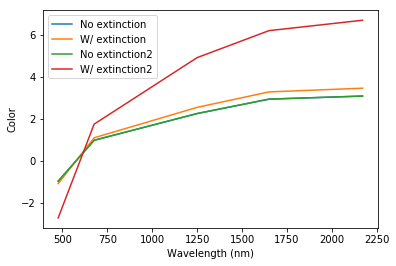

In [2006]:
stars = 0
while(stars == 0):
    count, array, idx, color = findStar()

    #print(GK[idx])
    if(count > 1):
        ID = np.random.randint(0,len(array))
        starData = [good_bands[ID,0],good_bands[ID,1],good_bands[ID,2],good_bands[ID,3],good_bands[ID,4],good_bands[ID,5]]
        starGaiaFlux = [goodGflux[ID],goodGBflux[ID],goodGRflux[ID]]
        starGaiaFlux_er = [goodGflux_er[ID],goodGBflux_er[ID],goodGRflux_er[ID]]
        TmassError = [goodJ_err[ID],goodH_err[ID],goodK_err[ID]]
        starColor = color[ID]
        checkdata = np.array(copy.copy(starData))
        checkdata = checkdata[~np.isnan(checkdata)]

        checkFluxes = np.array(copy.copy(starGaiaFlux))
        checkFluxes = checkFluxes[~np.isnan(checkFluxes)]
        
        checkFluxes_er = np.array(copy.copy(starGaiaFlux_er))
        checkFluxes_er = checkFluxes_er[~np.isnan(checkFluxes_er)]

        check2mass = np.array(copy.copy(TmassError))
        check2mass = check2mass[~np.isnan(check2mass)]
        
        stars = stars + 1
    else:
        print('No matched G-K values. Trying Again')


n = 0
if((len(checkdata) != len(starData)) or (len(checkFluxes) != len(starGaiaFlux)) \
   or (len(checkFluxes_er) != len(starGaiaFlux_er)) or (len(check2mass) != len(TmassError))):
    print('Error: 1 or more data values contained nan value.\nSelect new star')
else:
    MagUncert = []
    for i in range(len(starGaiaFlux)):
        flux = starGaiaFlux[i]
        flux_er = starGaiaFlux_er[i]
        if(i == 0):
            Mag_er = MagError(flux,flux_er,0.001)
            #Mag_er = MagError(flux,flux_er,0.01)
            MagUncert.append(Mag_er)
        else:
            Mag_er = MagError(flux,flux_er,10**-2.5)
            #Mag_er = MagError(flux,flux_er,0.03)
            MagUncert.append(Mag_er)
    MagUncert = np.array(MagUncert)
    MagUncert = np.append(MagUncert, TmassError)
    n = n + 1

    print('Star data is good')
    print(idx,color)
    relBands, extBands = addExtinctionStar(starData,idx,0.5)
    relBands2, extBands2 = addExtinctionStar(starData,idx,6.0)
    plt.plot(wvl,relBands,label='No extinction')
    plt.plot(wvl,extBands,label='W/ extinction')
    plt.plot(wvl,relBands2,label='No extinction2')
    plt.plot(wvl,extBands2,label='W/ extinction2')
    plt.legend()
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Color')
    plt.show()

[0.001      0.00316228 0.00316228 0.022      0.022      0.023     ]
Reduced X^2 val: 86.4913393285331
Extinction value computed: 0.8
G-K color computed: [13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 16, 16, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 33, 33, 32, 32, 32]
Actual G-K color: 1.2443
8


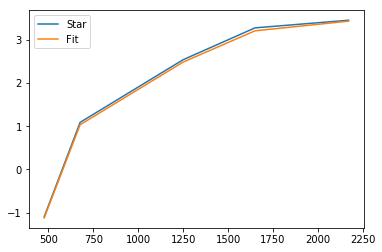

In [2008]:
# StarFitQuad(starBands,color_mags,starError,color_std):
# return best_fit, new_starBands, newStarError, chi_val, Chi2_vals
br = pickle.load(open('BrightTemplates_Av.pickle', 'rb'))
dm = pickle.load(open('FaintTemplates_Av.pickle', 'rb'))
bothChi2 = []
avChi2 = []
GKfit = []
fits = []
for i in range(len(Av)):
    curAv = []
    curAv = np.array(br[Av[i]])
    Chi2 = []
    #for j in range(len(curAv[0])):    
    #fit, new_Bands, newStarError, chi, GKval = StarFitQuad(extBands,curAv[0],MagUncert,curAv[1],spec)
    fit, new_Bands, newStarError, chi, GKval = StarFitting(extBands,curAv[0],MagUncert,curAv[1],spec)
    #fit, new_Bands, chi, GKval = StarFit(extBands,curAv[0],curAv[1],spec)
    avChi2.append(chi)
    GKfit.append(GKval)
    fits.append(fit)
avChi2 = np.array(avChi2)
print(MagUncert)


# avChi2_dm = []
# GKfit_dm = []
# fits_dm = []
# for i in range(len(Av)):
#     curAv = []
#     curAv = np.array(dm[Av[i]])
#     Chi2 = []
#     #for j in range(len(curAv[0])):    
#     fit, new_Bands, newStarError, chi, GKval = StarFitQuad(extBands,curAv[0],MagUncert,curAv[1],spec)
#     avChi2_dm.append(chi)
#     GKfit_dm.append(GKval)
#     fits_dm.append(fit)
# avChi2_dm = np.array(avChi2_dm)


for i in range(len(avChi2)):
    if(avChi2[i] == np.min(avChi2)):
        print('Reduced X^2 val:', avChi2[i])
        print('Extinction value computed:',Av[i])
        print('G-K color computed:',GKfit[i])
        print('Actual G-K color:', starColor)
        print(i)
        bothChi2.append(avChi2[i])
        bestFit = fits[i]
        mags = np.array(br[Av[i]])

bestMag = mags[0,bestFit]        

plt.plot(wvl,extBands,label='Star')
plt.plot(wvl,bestMag,label='Fit')
plt.legend()
plt.show()


In [1729]:
import time

In [1753]:
#Gmags = Gmag - 5 * np.log10(Dist) + 5
start = time.time()
ExtVals = []
AO = 0.5
for ID in range(17000,17050):
#for ID in range(len(good_band)):
    curGK = good_GK[ID]
    diff_ar = list(abs(G_K_int - curGK))
    minVal = np.min(diff_ar)
    ix = diff_ar.index(minVal)
    
#     colorDiff = list(abs(G_K_int - tempColor))
#     minVal = np.min(colorDiff)
#     ind = colorDiff.index(minVal)
#     spec.append(ind)
    starBand = good_bands[ID]
    starData = [good_bands[ID,0],good_bands[ID,1],good_bands[ID,2],good_bands[ID,3],good_bands[ID,4],good_bands[ID,5]]
    starGaiaFlux = [goodGflux[ID],goodGBflux[ID],goodGRflux[ID]]
    starGaiaFlux_er = [goodGflux_er[ID],goodGBflux_er[ID],goodGRflux_er[ID]]
    TmassError = [goodJ_err[ID],goodH_err[ID],goodK_err[ID]]
    MagUncert = []
    for i in range(len(starGaiaFlux)):
        flux = starGaiaFlux[i]
        flux_er = starGaiaFlux_er[i]
        if(i == 0):
            #Mag_er = MagError(flux,flux_er,0.001)
            Mag_er = MagError(flux,flux_er,0.01)
            MagUncert.append(Mag_er)
        else:
            #Mag_er = MagError(flux,flux_er,10**-2.5)
            Mag_er = MagError(flux,flux_er,0.03)
            MagUncert.append(Mag_er)
    MagUncert = np.array(MagUncert)
    MagUncert = np.append(MagUncert, TmassError)
    
    relBands, extBands = addExtinctionStar(starData,ix,AO)
    
    
    AvChi = []
    for i in range(len(Av)):
        curAv = []
        curAv = np.array(br[Av[i]])
        Chi2 = []
        
        fit, new_Bands, newStarError, chi, GKval = StarFitting(extBands,curAv[0],MagUncert,curAv[1],spec)
        AvChi.append(chi)
    for i in range(len(AvChi)):
        if(AvChi[i] == np.min(AvChi)):
            ExtVals.append(Av[i])

            
ExtVals = np.array(ExtVals)    
Accuracy = ExtVals - AO
Accuracy = np.array(Accuracy)

end = time.time()
print('Total Time:',end - start)
    
    

Total Time: 59.372488021850586


In [197]:




print(starDatas[0])

[ 17.22930527  17.29841805  17.03253937  16.55800056  16.46899986
  16.0189991 ]


     Bright Reduced X^2: 0.733422761779 

Inputted Extinction: 7.9
Bright: Computed Extinction: 7.5
G_K_int Color: 1.71664813182
Star Color: 1.83920860291
Bright: Computed StarColor: 2.13216482547


     Faint Reduced X^2: 0.307518550659 

Inputted Extinction: 7.9
Faint: Computed Extinction: 8.9
G_K_int Color: 1.71664813182
Star Color: 1.83920860291
Faint: Computed StarColor: 1.24432682763


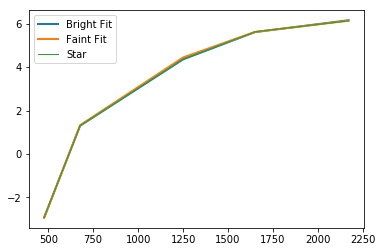




Total Time: 3.873750686645508


In [32]:
br = pickle.load(open('BrightTemplates_Av.pickle', 'rb'))
dm = pickle.load(open('FaintTemplates_Av.pickle', 'rb'))
#Gmags = Gmag - 5 * np.log10(Dist) + 5

starDatas = np.transpose([br_Gmag,br_GBmag,br_GRmag,br_Jmag,br_Hmag,br_Kmag])
starGaiaFluxs = np.transpose([br_Gflux,br_GBflux,br_GRflux])
starGaiaFlux_ers = np.transpose([br_Gflux_er,br_GBflux_er,br_GRflux_er])
TmassErrors = np.transpose([J_unc_br,H_unc_br,K_unc_br])

start = time.time()

all_Av_br = []
all_Av_dm = []
#for m in range(0,50):

randExt = np.random.randint(0,len(Av))
AO = Av[randExt]

ID = np.random.randint(0,len(br_Gmag))
curGK = br_GK[ID]
diff_ar = list(abs(G_K_int - curGK))
minVal = np.min(diff_ar)
ix = diff_ar.index(minVal)
StarColor = br_GK[ID]

#     colorDiff = list(abs(G_K_int - tempColor))
#     minVal = np.min(colorDiff)
#     ind = colorDiff.index(minVal)
#     spec.append(ind)
#starBand = all_BrightStars[ID]
starBand = all_BrightStars[ID]
#starData = starDatas[ID]
starGaiaFlux = starGaiaFluxs[ID]
starGaiaFlux_er = starGaiaFlux_ers[ID]
TmassError = TmassErrors[ID]

checkdata = np.array(copy.copy(starBand))
checkdata = checkdata[~np.isnan(checkdata)]

checkFluxes = np.array(copy.copy(starGaiaFlux))
checkFluxes = checkFluxes[~np.isnan(checkFluxes)]

checkFluxes_er = np.array(copy.copy(starGaiaFlux_er))
checkFluxes_er = checkFluxes_er[~np.isnan(checkFluxes_er)]

check2mass = np.array(copy.copy(TmassError))
check2mass = check2mass[~np.isnan(check2mass)]


if((len(checkdata) != len(starBand)) or (len(checkFluxes) != len(starGaiaFlux)) \
   or (len(checkFluxes_er) != len(starGaiaFlux_er)) or (len(check2mass) != len(TmassError))):
    print('Error: 1 or more data values contained nan value.\nSelect new star')
else:


    MagUncert = []
    for i in range(len(starGaiaFlux)):
        flux = starGaiaFlux[i]
        flux_er = starGaiaFlux_er[i]
        if(i == 0):
            #Mag_er = MagError(flux,flux_er,0.001)
            Mag_er = MagError(flux,flux_er,0.01)
            MagUncert.append(Mag_er)
        else:
            #Mag_er = MagError(flux,flux_er,10**-2.5)
            Mag_er = MagError(flux,flux_er,0.03)
            MagUncert.append(Mag_er)
    MagUncert = np.array(MagUncert)
    MagUncert = np.append(MagUncert, TmassError)

    relBands, extBands = addExtinctionStar(starBand,ix,AO)

    GKvals = []
    AvChi = []
    fits = []
    GKvals_dm = []
    AvChi_dm = []
    fits_dm = []
    for i in range(len(Av)):
        curAv = []
        curAv = np.array(br[Av[i]])
        curAv_dm = []
        curAv_dm = np.array(dm[Av[i]])
        Chi2 = []
        #print(len(BrightTemps))
        fit, chi, GKval, chi_array = StarFitQuad(extBands,curAv[0],MagUncert,curAv[1],spec_br)
        fit_dm, chi_dm, GKval_dm, chi_array_dm = StarFitQuad(extBands,curAv_dm[0],MagUncert,curAv_dm[1],spec_dm)
        #fit, new_Bands, chi, GKval = StarFit(extBands,curAv[0],curAv[1],spec)
        AvChi.append(chi)
        GKvals.append(GKval)
        fits.append(fit)
        AvChi_dm.append(chi_dm)
        GKvals_dm.append(GKval_dm)
        fits_dm.append(fit_dm)
    
    
    for i in range(len(AvChi)):
        if(AvChi[i] == np.min(AvChi)):
            all_Av_br.append(abs(Av[i]-AO))
            ext = Av[i]
            mags = np.array(br[Av[i]])
            chi_val = AvChi[i]
            GK_val = GKvals[i]
            bestFit = fits[i]
    print('     Bright Reduced X^2:',chi_val,'\n')  
    print('Inputted Extinction:',AO)
    print('Bright: Computed Extinction:',ext)
    print('G_K_int Color:',G_K_int[ix])
    print('Star Color:',StarColor)
    print('Bright: Computed StarColor:',GK_val)
    bestMag = mags[0,bestFit]        
    
    for i in range(len(AvChi_dm)):
        if(AvChi_dm[i] == np.min(AvChi_dm)):
            all_Av_dm.append(abs(Av[i]-AO))
            ext_dm = Av[i]
            mags_dm = np.array(dm[Av[i]])
            chi_val_dm = AvChi_dm[i]
            GK_val_dm = GKvals_dm[i]
            bestFit_dm = fits_dm[i]
    print('\n\n     Faint Reduced X^2:',chi_val_dm,'\n')  
    print('Inputted Extinction:',AO)
    print('Faint: Computed Extinction:',ext_dm)
    print('G_K_int Color:',G_K_int[ix])
    print('Star Color:',StarColor)
    print('Faint: Computed StarColor:',GK_val_dm)
    bestMag_dm = mags_dm[0,bestFit_dm]        

    wvl = [477,677,1250,1650,2170]
    plt.plot(wvl,bestMag,label='Bright Fit',linewidth = 2.0)
    plt.plot(wvl,bestMag_dm,label='Faint Fit',linewidth=2.0)
    plt.plot(wvl,extBands,label='Star',linewidth = 1.0)
    plt.legend()
    plt.show()

end = time.time()
print('\n\n\nTotal Time:',end-start)


In [2469]:
np.max(br_GK)

2.7754154205322266

In [2274]:
print(len(spec),len(BrightTemps))

54 114


0.1918367346938775
0.10000000000000009


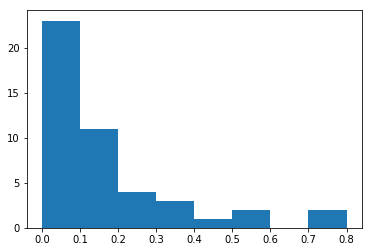

In [2255]:
all_Av = np.array(all_Av)
print(np.nanmean(all_Av))
values = all_Av[~np.isnan(all_Av)]
print(np.median(values))
bins = np.arange(0,np.max(values),0.1)
plt.hist(all_Av,bins=bins,normed=False)
plt.show()

In [150]:
br = pickle.load(open('BrightTemplates_Av.pickle', 'rb'))
dm = pickle.load(open('FaintTemplates_Av.pickle', 'rb'))
#Gmags = Gmag - 5 * np.log10(Dist) + 5
start = time.time()
all_Av = []
all_chi = []
starDatas = np.transpose([br_Gmag,br_GBmag,br_GRmag,br_Jmag,br_Hmag,br_Kmag])
starGaiaFluxs = np.transpose([br_Gflux,br_GBflux,br_GRflux])
starGaiaFlux_ers = np.transpose([br_Gflux_er,br_GBflux_er,br_GRflux_er])
TmassErrors = np.transpose([J_unc_br,H_unc_br,K_unc_br])
for m in range(100):
    


    
    #for m in range(0,50):

    randExt = np.random.randint(0,len(Av))
    AO = Av[randExt]
    #AO = 0
    ID = np.random.randint(0,len(br_Gmag))
    curGK = br_GK[ID]
    diff_ar = list(abs(G_K_int - curGK))
    minVal = np.min(diff_ar)
    ix = diff_ar.index(minVal)
    StarColor = br_GK[ID]

    #     colorDiff = list(abs(G_K_int - tempColor))
    #     minVal = np.min(colorDiff)
    #     ind = colorDiff.index(minVal)
    #     spec.append(ind)
    starBand = all_BrightStars[ID]
    #starData = starDatas[ID]
    starGaiaFlux = starGaiaFluxs[ID]
    starGaiaFlux_er = starGaiaFlux_ers[ID]
    TmassError = TmassErrors[ID]

    checkdata = np.array(copy.copy(starBand))
    checkdata = checkdata[~np.isnan(checkdata)]

    checkFluxes = np.array(copy.copy(starGaiaFlux))
    checkFluxes = checkFluxes[~np.isnan(checkFluxes)]

    checkFluxes_er = np.array(copy.copy(starGaiaFlux_er))
    checkFluxes_er = checkFluxes_er[~np.isnan(checkFluxes_er)]

    check2mass = np.array(copy.copy(TmassError))
    check2mass = check2mass[~np.isnan(check2mass)]


    if((len(checkdata) != len(starBand)) or (len(checkFluxes) != len(starGaiaFlux)) \
       or (len(checkFluxes_er) != len(starGaiaFlux_er)) or (len(check2mass) != len(TmassError))):
        print('Error: 1 or more data values contained nan value.\nSelect new star')
    else:


        MagUncert = []
        for i in range(len(starGaiaFlux)):
            flux = starGaiaFlux[i]
            flux_er = starGaiaFlux_er[i]
            if(i == 0):
                Mag_er = MagError(flux,flux_er,0.001)
                #Mag_er = MagError(flux,flux_er,0.01)
                MagUncert.append(Mag_er)
            else:
                Mag_er = MagError(flux,flux_er,10**-2.5)
                #Mag_er = MagError(flux,flux_er,0.03)
                MagUncert.append(Mag_er)
        MagUncert = np.array(MagUncert)
        MagUncert = np.append(MagUncert, TmassError)

        relBands, extBands = addExtinctionStar(starBand,ix,AO)

        GKvals = []
        AvChi = []
        fits = []
        allChi2Vals = []
        for i in range(len(Av)):
            curAv = []
            curAv = np.array(br[Av[i]])
            Chi2 = []
            #print(len(BrightTemps))
            fit, chi, GKval, chi_array = StarFitQuad(extBands,curAv[0],MagUncert,curAv[1],spec_br)

            AvChi.append(chi)
            GKvals.append(GKval)
            fits.append(fit)
            allChi2Vals.append(chi_array)
        for i in range(len(AvChi)):
            if(AvChi[i] == np.min(AvChi)):
                all_Av.append(abs(Av[i]-AO))
                ext = Av[i]
                mags = np.array(br[Av[i]])
                chi_val = AvChi[i]
                all_chi.append(chi_val)
                GK_val = GKvals[i]
                bestFit = fits[i]
#         print('     Bright Reduced X^2:',chi_val,'\n')  
#         print('Inputted Extinction:',AO)
#         print('Bright: Computed Extinction:',ext)
#         print('G_K_int Color:',G_K_int[ix])
#         print('Star Color:',StarColor)
#         print('Bright: Computed StarColor:',GK_val)
        bestMag = mags[0,bestFit]        
    
    

end = time.time()
print('\n\n\nTotal Time:',end-start)
print('\n\nLength of ')

Error: 1 or more data values contained nan value.
Select new star
Error: 1 or more data values contained nan value.
Select new star



Total Time: 160.3072748184204


Length of 


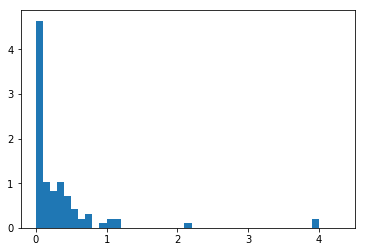

0.15
0.362244897959


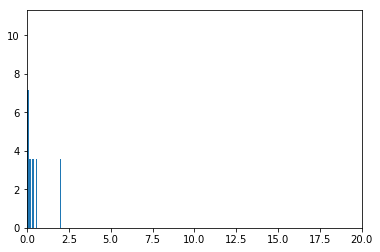

0.257285022273
2.00650758835 2.00650758835 0.7 4.4

 0.0487342511764
0.2


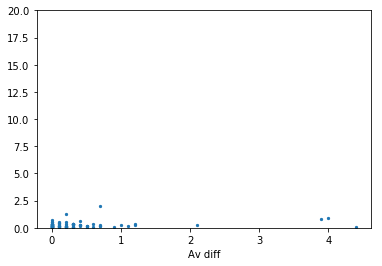

In [151]:
bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]
bins = np.arange(0,np.max(all_Av),0.1)
plt.hist(all_Av,bins=bins,normed=True)
plt.show()
print(np.median(all_Av))
print(np.mean(all_Av))
plt.hist(all_chi,700,normed=True)
plt.xlim([0,20])
plt.show()
print(np.mean(all_chi))

maxValue = np.max(all_chi)
indx = all_chi.index(maxValue)
print(all_chi[indx],np.max(all_chi),all_Av[indx],np.max(all_Av))
print('\n',all_chi[50])
print(all_Av[50])

plt.scatter(all_Av,all_chi,s=5.0)
plt.ylim([0,20])
plt.xlabel('Av diff')
plt.show()

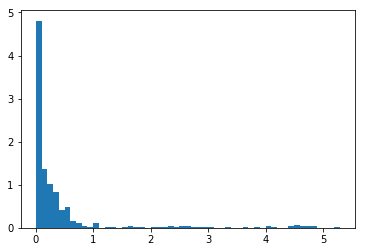

0.1
0.368346774194


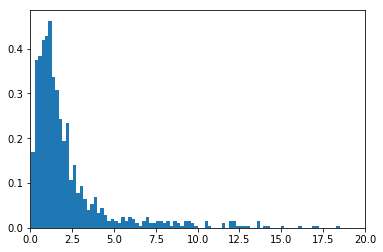

2.68996651586
145.03862526 145.03862526 4.7 5.3

 2.51206495725
0.1


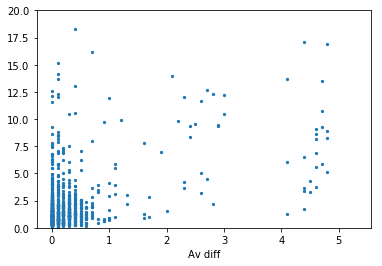

In [149]:
bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]
bins = np.arange(0,np.max(all_Av),0.1)
plt.hist(all_Av,bins=bins,normed=True)
plt.show()
print(np.median(all_Av))
print(np.mean(all_Av))
plt.hist(all_chi,700,normed=True)
plt.xlim([0,20])
plt.show()
print(np.mean(all_chi))

maxValue = np.max(all_chi)
indx = all_chi.index(maxValue)
print(all_chi[indx],np.max(all_chi),all_Av[indx],np.max(all_Av))
print('\n',all_chi[50])
print(all_Av[50])

plt.scatter(all_Av,all_chi,s=5.0)
plt.ylim([0,20])
plt.xlabel('Av diff')
plt.show()

In [103]:

X, Y = np.meshgrid(Av,BrightTemps[:,9])


[    0.          6931.64373199]
[ 100.  100.  100. ...,  100.  100.  100.]


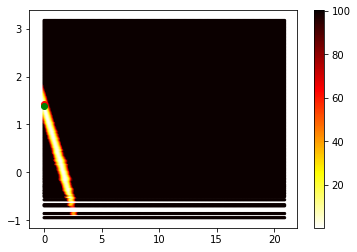

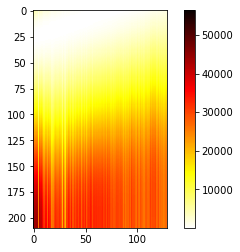

100.108602302 0.130988711003


In [104]:
final_GKaV = []
allChi2Vals = np.array(allChi2Vals)
for i in range(len(allChi2Vals)):
    for j in range(len(allChi2Vals[i])):
        final_GKaV.append([Av[i],allChi2Vals[i,j]])
final_GKaV = np.array(final_GKaV)
print(final_GKaV[0])

XY = np.transpose([X,Y])
grid = XY[0]

for j in range(1,len(XY)):
    grid = np.vstack((grid,XY[j]))

Chi2List = np.array(copy.copy(allChi2Vals))
Chi2List = Chi2List.ravel()    


for i in range(len(Chi2List)):
    if(Chi2List[i] > chi_val+100):
        Chi2List[i] = 100
print(Chi2List)
plt.scatter(grid[:,0],grid[:,1],c=Chi2List,alpha=0.99,s=5)
plt.set_cmap('hot_r')
plt.colorbar()
plt.scatter(AO,StarColor,c='r')
plt.scatter(ext,GK_val,c='g')
plt.show()

plt.imshow(allChi2Vals)
plt.set_cmap('hot_r')
plt.colorbar()
plt.show()
print(np.max(Chi2List),np.min(Chi2List))

In [209]:
br = pickle.load(open('BrightTemplates_Av.pickle', 'rb'))
dm = pickle.load(open('FaintTemplates_Av.pickle', 'rb'))
#Gmags = Gmag - 5 * np.log10(Dist) + 5

starDatas = np.transpose([dm_Gmag,dm_GBmag,dm_GRmag,dm_Jmag,dm_Hmag,dm_Kmag])
starGaiaFluxs = np.transpose([dm_Gflux,dm_GBflux,dm_GRflux])
starGaiaFlux_ers = np.transpose([dm_Gflux_er,dm_GBflux_er,dm_GRflux_er])
TmassErrors = np.transpose([J_unc_dm,H_unc_dm,K_unc_dm])

start = time.time()

all_Av = []
#for m in range(0,50):

randExt = np.random.randint(0,len(Av))
AO = Av[randExt]

ID = np.random.randint(0,len(dm_Gmag))
curGK = dm_GK[ID]
diff_ar = list(abs(G_K_int - curGK))
minVal = np.min(diff_ar)
ix = diff_ar.index(minVal)
StarColor = dm_GK[ID]

#     colorDiff = list(abs(G_K_int - tempColor))
#     minVal = np.min(colorDiff)
#     ind = colorDiff.index(minVal)
#     spec.append(ind)
starBand = all_dimStars[ID]
#starData = starDatas[ID]
starGaiaFlux = starGaiaFluxs[ID]
starGaiaFlux_er = starGaiaFlux_ers[ID]
TmassError = TmassErrors[ID]

checkdata = np.array(copy.copy(starBand))
checkdata = checkdata[~np.isnan(checkdata)]

checkFluxes = np.array(copy.copy(starGaiaFlux))
checkFluxes = checkFluxes[~np.isnan(checkFluxes)]

checkFluxes_er = np.array(copy.copy(starGaiaFlux_er))
checkFluxes_er = checkFluxes_er[~np.isnan(checkFluxes_er)]

check2mass = np.array(copy.copy(TmassError))
check2mass = check2mass[~np.isnan(check2mass)]


if((len(checkdata) != len(starBand)) or (len(checkFluxes) != len(starGaiaFlux)) \
   or (len(checkFluxes_er) != len(starGaiaFlux_er)) or (len(check2mass) != len(TmassError))):
    print('Error: 1 or more data values contained nan value.\nSelect new star')
else:


    MagUncert = []
    for i in range(len(starGaiaFlux)):
        flux = starGaiaFlux[i]
        flux_er = starGaiaFlux_er[i]
        if(i == 0):
            Mag_er = MagError(flux,flux_er,0.001)
            #Mag_er = MagError(flux,flux_er,0.01)
            MagUncert.append(Mag_er)
        else:
            Mag_er = MagError(flux,flux_er,10**-2.5)
            #Mag_er = MagError(flux,flux_er,0.03)
            MagUncert.append(Mag_er)
    MagUncert = np.array(MagUncert)
    MagUncert = np.append(MagUncert, TmassError)

    relBands, extBands = addExtinctionStar(starBand,ix,AO)

    GKvals = []
    AvChi = []
    fits = []
    allChi2Vals = []
    for i in range(len(Av)):
        curAv = []
        curAv = np.array(dm[Av[i]])
        Chi2 = []
        #print(len(BrightTemps))
        fit, chi, GKval, chi_array = StarFitQuad(extBands,curAv[0],MagUncert,curAv[1],spec_dm)
       
        AvChi.append(chi)
        GKvals.append(GKval)
        fits.append(fit)
        allChi2Vals.append(chi_array)
    for i in range(len(AvChi)):
        if(AvChi[i] == np.min(AvChi)):
            all_Av.append(abs(Av[i]-AO))
            ext = Av[i]
            mags = np.array(br[Av[i]])
            chi_val = AvChi[i]
            GK_val = GKvals[i]
            bestFit = fits[i]
    print('     Faint Reduced X^2:',chi_val,'\n')  
    print('Inputted Extinction:',AO)
    print('Faint: Computed Extinction:',ext)
    print('G_K_int Color:',G_K_int[ix])
    print('Star Color:',StarColor)
    print('Faint: Computed StarColor:',GK_val)
    bestMag = mags[0,bestFit]        
    
    

end = time.time()
print('\n\n\nTotal Time:',end-start)
print('\n\nLength of ')

     Faint Reduced X^2: 0.52236662854 

Inputted Extinction: 4.7
Faint: Computed Extinction: 3.5
G_K_int Color: 2.13216482547
Star Color: 2.1550321579
Faint: Computed StarColor: 2.86335258953



Total Time: 1.7895309925079346


Length of 


[     0.          41458.21349078]
[ 100.  100.  100. ...,  100.  100.  100.]


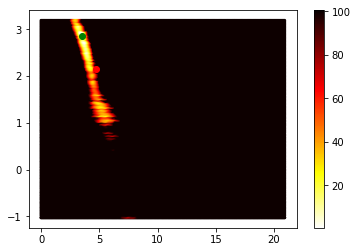

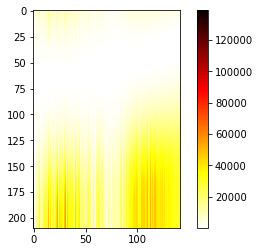

100.499059645 0.52236662854


In [210]:
X1, Y1 = np.meshgrid(Av,FaintTemps[:,9])

final_GKaV = []
allChi2Vals = np.array(allChi2Vals)
for i in range(len(allChi2Vals)):
    for j in range(len(allChi2Vals[i])):
        final_GKaV.append([Av[i],allChi2Vals[i,j]])
final_GKaV = np.array(final_GKaV)
print(final_GKaV[0])

XY = np.transpose([X1,Y1])
grid = XY[0]

for j in range(1,len(XY)):
    grid = np.vstack((grid,XY[j]))

Chi2List = np.array(copy.copy(allChi2Vals))
Chi2List = Chi2List.ravel()    

for i in range(len(Chi2List)):
    if(Chi2List[i] > chi_val+100):
        Chi2List[i] = 100
print(Chi2List)
plt.scatter(grid[:,0],grid[:,1],c=Chi2List,alpha=0.99,s=5)
plt.set_cmap('hot_r')
plt.colorbar()
plt.scatter(AO,StarColor,c='r')
plt.scatter(ext,GK_val,c='g')
plt.show()

plt.imshow(allChi2Vals)
plt.set_cmap('hot_r')
plt.colorbar()
plt.show()
print(np.max(Chi2List),np.min(Chi2List))